In [1]:
using Random
Random.seed!(13)

using CSV
using Plots
using DataFrames
using Statistics
using Missings
using Distributions
using StatsPlots
using LowRankModels, LinearAlgebra

In [37]:
include("proxgrad.jl")
df = CSV.read("airline.csv")

,airline_name,link,title,author
,String,String,String,String
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann
3,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin
4,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Tercon Bojan
5,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,L James
6,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Dzano Edin
7,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,M Tushishvili
8,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,M Znidar
9,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Tercon Bojan


In [38]:
# Organize and display features along with variable type
feature_names = names(df)
for i in 1:20
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	airline_name			String
2	link			String
3	title			String
4	author			String
5	author_country			Union{Missing, String}
6	date			Dates.Date
7	content			String
8	aircraft			Union{Missing, String}
9	type_traveller			Union{Missing, String}
10	cabin_flown			Union{Missing, String}
11	route			Union{Missing, String}
12	overall_rating			Union{Missing, Float64}
13	seat_comfort_rating			Union{Missing, Float64}
14	cabin_staff_rating			Union{Missing, Float64}
15	food_beverages_rating			Union{Missing, Float64}
16	inflight_entertainment_rating			Union{Missing, Float64}
17	ground_service_rating			Union{Missing, Float64}
18	wifi_connectivity_rating			Union{Missing, Float64}
19	value_money_rating			Union{Missing, Float64}
20	recommended			Int64


Bag of words & manyhot function for text features

In [39]:
# Bag of words function to add bag of word features to data 

bag_of_words = ["good",
                "first",
                "entertainment",
                "friendly",
                "new",
                "comfortable",
                "great",
                "delayed",
                "excellent",
                "nice",
                "late",
                "better",
                "offered",
                "free",
                "delay",
                "helpful",
                "early",
                "pleasant",
                "best",
                "available",
                "efficient",
                "recommend",
                "uncomfortable",
                "cancelled",
                "comfort",
                "problems",
                "delays",
                "united",
                "cheap",
                "awful"
                ]

"Computes a manyhot vector for every entry in column given a bag of words"
function manyhot(column, words=bag_of_words)
    result = zeros(size(column,1), size(words,1))
    for i = 1:size(column,1)
        for j in 1:size(words,1)
            if occursin(words[j],column[i])
                result[i,j] = Int(1)
            end
        end
    end
    convert(Array{Int64,2},result)
end

manyhot

Filter data set to remove rows with missing features.
Split training and testing sets.

In [40]:
# Reduce number of datapoints for computation time

# Filter data to only consider entries with overall rating
df_OR = df[.!(ismissing.(df[!, :overall_rating])), :];

df_OR_filtered = df_OR[.!(ismissing.(df_OR[!, :seat_comfort_rating])), :]; 
data_OR_filtered = df_OR_filtered[.!(ismissing.(df_OR_filtered[!, :cabin_staff_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(df_OR_filtered[!, :content])), :];

# Now adding food_beverages_rating, inflight_entertainment_rating, and value money rating
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :food_beverages_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :inflight_entertainment_rating])), :];
data_OR_filtered = data_OR_filtered[.!(ismissing.(data_OR_filtered[!, :value_money_rating])), :];

train_proportion = 0.8
n = size(data_OR_filtered, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
println("Size of train: ", string(round(train_proportion*n)))
println("Size of test: ", string(round(n-train_proportion*n)))

# Create manyhot bag of words binary array and add feature columns to original airline dataframe
df_content = data_OR_filtered[:, :content]
manyhot_data = manyhot(df_content)
for i = 1:size(bag_of_words,1)
   data_OR_filtered[!,Symbol(bag_of_words[i])] = manyhot_data[:,i]
end

target = data_OR_filtered[:, :overall_rating]

# Filter data for entries with only seat_comfort, cabin_staff
# df_OR_filtered = df_OR[.!(ismissing.(df[!, :seat_comfort_rating])), :]; 
# df_OR_filtered = df_OR[.!(ismissing.(df[!, :cabin_staff_rating])), :]; 
# data_OR_filtered = df_OR_filtered[:, filter(col -> (col != :overall_rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data_OR_filtered[1:ntrain,:]

# the following variable records the features of examples in the test set
test_x = data_OR_filtered[ntrain+1:end,:]

# the following variable records the labels of examples in the training set
train_y = target[1:ntrain]
train_y = collect(skipmissing(train_y))
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:end]
test_y = collect(skipmissing(test_y));

Size of dataset: 28341
Size of train: 22673.0
Size of test: 5668.0


In [41]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    "Fill this in."
    num = size(y,1)
    error = sum(abs.((y.-pred).^2))/num
    return error
end

"""This function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", zeromin=true)
end

plot_pred_true

In [42]:
"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

labels_all = [
  :overall_rating,
  :seat_comfort_rating,
  :cabin_staff_rating,
  :food_beverages_rating,
  :inflight_entertainment_rating,
  :ground_service_rating,
  :wifi_connectivity_rating,
  :value_money_rating,
  :recommended
]

labels_real = [
    :seat_comfort_rating,
    :cabin_staff_rating,
    :food_beverages_rating,
    :inflight_entertainment_rating,
    :value_money_rating
]


symbol_words = Symbol[]

for word in bag_of_words
    push!(symbol_words,Symbol(word))
end

labels_all_words = vcat(labels_all,symbol_words);
labels_real_words = vcat(labels_real,symbol_words);

Filter data sets to only include features of interest. Current models includes the following labels:

   * Seat comfort rating
   * Cabin staff rating
   * Food beverage rating
   * Inflight entertainment rating
   * Value money rating
   * Bag of words text (30 words chosen)

In [43]:
# # Only converting for seat comfort and cabin staff
# train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);
# test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating])]);
# size(train_vals_real,1)
# any(ismissing,train_vals_real)

# Only converting for seat comfort, cabin staff, food/beverage, and inflight entertainment
train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);
test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real), [:seat_comfort_rating,:cabin_staff_rating,:food_beverages_rating,:inflight_entertainment_rating,:value_money_rating])]);
size(train_vals_real,1)
any(ismissing,train_vals_real)

# Only converting for seat comfort, cabin staff, food/beverage, and inflight entertainment AND BAG OF WORDS
# train_vals_real = convert(Matrix,train_x[:,filter(col -> (col in labels_real_words), labels_all_words)])
# test_vals_real = convert(Matrix,test_x[:,filter(col -> (col in labels_real_words), labels_all_words)])
# size(train_vals_real,1)
# any(ismissing,train_vals_real)

train_vals_real = convert(Array{Float64,2},train_vals_real)
test_vals_real = convert(Array{Float64,2},test_vals_real)

# # Add offset
train_vals_real = [train_vals_real ones(size(train_vals_real,1))];
test_vals_real = [test_vals_real ones(size(test_vals_real,1))];

[train_vals_real train_y]

22673×7 Array{Float64,2}:
 4.0  4.0  4.0  0.0  4.0  1.0   7.0
 4.0  5.0  4.0  1.0  5.0  1.0  10.0
 5.0  5.0  4.0  0.0  5.0  1.0   9.0
 4.0  4.0  3.0  1.0  4.0  1.0   8.0
 4.0  2.0  1.0  2.0  2.0  1.0   4.0
 4.0  4.0  3.0  3.0  4.0  1.0   9.0
 4.0  4.0  1.0  0.0  3.0  1.0   5.0
 5.0  5.0  4.0  3.0  4.0  1.0   9.0
 4.0  3.0  4.0  1.0  4.0  1.0   8.0
 5.0  5.0  4.0  4.0  4.0  1.0  10.0
 4.0  4.0  4.0  4.0  4.0  1.0   9.0
 4.0  5.0  3.0  3.0  5.0  1.0   7.0
 4.0  4.0  4.0  0.0  4.0  1.0   8.0
 ⋮                        ⋮        
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 2.0  1.0  1.0  1.0  1.0  1.0   1.0
 1.0  2.0  1.0  1.0  1.0  1.0   1.0
 1.0  2.0  2.0  1.0  1.0  1.0   1.0
 2.0  4.0  3.0  1.0  2.0  1.0   2.0
 1.0  2.0  1.0  1.0  1.0  1.0   1.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0
 5.0  5.0  2.0  3.0  5.0  1.0  10.0
 2.0  4.0  2.0  1.0  3.0  1.0   6.0
 1.0  1.0  1.0  1.0  1.0  1.0   1.0

# L1 Loss Function

In [44]:
# L1 Loss
loss_L1 = 1/n*L1Loss()
λ = 0
# Quad Regularizer
reg = QuadReg(λ)

w_L1 = proxgrad(loss_L1, reg, train_vals_real, train_y, maxiters=1000)
train_pred = train_vals_real*w_L1
test_pred = test_vals_real*w_L1
train_MSE = MSE(train_pred,train_y)
test_MSE = MSE(test_pred,test_y)

println("Train MSE:\t", train_MSE)
println("Test MSE: \t", test_MSE)

Train MSE:	2.4085693958718646
Test MSE: 	2.3831797825297385


Determine optimal Quadratic λ parameter for L1 model. Currently very difficult to converge with high iteration numbers. Currently ineffective.

In [45]:
# L1 Loss
loss_L1 = 1/n*L1Loss()
# Quad Regularizer
# reg = λ*QuadReg()
# reg = ZeroReg()

train_MSE_array = zeros(101)
test_MSE_array = zeros(101)

for i = 0:100
    
    λ = i/100
    print(λ)
    reg = QuadReg(λ)
    w_L1 = proxgrad(loss_L1, reg, train_vals_real, train_y, maxiters=2)
    train_pred = train_vals_real*w_L1
    test_pred = test_vals_real*w_L1
    train_MSE = MSE(train_pred,train_y)
    test_MSE = MSE(test_pred,test_y)
    train_MSE_array[i+1] = train_MSE 
    test_MSE_array[i+1] = test_MSE
end

plot(collect(0:0.01:1),train_MSE_array)
plot!(collect(0:0.01:1),test_MSE_array)
println("Train MSE:\t", minimum(train_MSE_array))
println("Test MSE: \t", minimum(test_MSE))

0.00.010.020.030.040.050.060.070.080.090.10.110.120.130.140.150.160.170.180.190.20.210.220.230.240.250.260.270.280.290.30.310.320.330.340.350.360.370.380.390.40.410.420.430.440.450.460.470.480.490.50.510.520.530.540.550.560.570.580.590.60.610.620.630.640.650.660.670.680.690.70.710.720.730.740.750.760.770.780.790.80.810.820.830.840.850.860.870.880.890.90.910.920.930.940.950.960.970.980.991.0Train MSE:	3.12020476194991
Test MSE: 	6.781837338533736


# L2 Loss Function

In [46]:
loss_L2 = 1/n*QuadLoss()
λ = 0.0001
# Quad Regularizer
reg = QuadReg(λ)

w_L2 = proxgrad(loss_L2, reg, train_vals_real, train_y, maxiters=1500)
train_pred = train_vals_real*w_L2
test_pred = test_vals_real*w_L2
train_MSE = MSE(train_pred,train_y)
test_MSE = MSE(test_pred,test_y)

println("Train MSE:\t", train_MSE)
println("Test MSE: \t", test_MSE)

Train MSE:	2.2739376110138494
Test MSE: 	2.0956830319040662


0.00.0010.0020.0030.0040.0050.0060.0070.0080.0090.01
Min Train MSE:	2.274778692190919
Min Test MSE: 	2.1038323790110725
Optimal λ: 	0.0


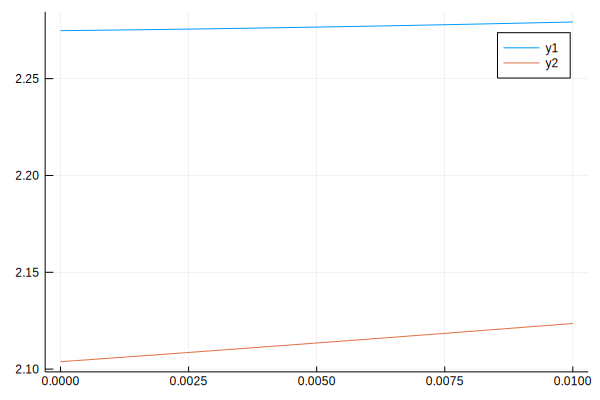

In [47]:
# L2 Loss
loss_L2 = 1/n*QuadLoss()
# Quad Regularizer
# reg = λ*QuadReg()
# reg = ZeroReg()

train_MSE_array = Float64[]
test_MSE_array = Float64[]
λs = 0:.001:0.01

for λ in λs
    print(λ)
    reg = QuadReg(λ)
    w_L2 = proxgrad(loss_L2, reg, train_vals_real, train_y, maxiters=1000)
    train_pred = train_vals_real*w_L2
    test_pred = test_vals_real*w_L2
    train_MSE = MSE(train_pred,train_y)
    test_MSE = MSE(test_pred,test_y)
    push!(train_MSE_array,train_MSE)
    push!(test_MSE_array,test_MSE)
end
println("")
println("Min Train MSE:\t", minimum(train_MSE_array))
println("Min Test MSE: \t", minimum(test_MSE_array))
println("Optimal λ: \t", λs[argmin(test_MSE_array)])
plot(λs,train_MSE_array)
plot!(λs,test_MSE_array)

In [48]:
# loss_L2 = 1/n*QuadLoss()
# loss_L2 = BvSLoss(5, bin_loss=LogisticLoss()
loss_L2 = BvSLoss(5)
# Quad Regularizer
reg = NonNegConstraint()

w_L2 = proxgrad(loss_L2, reg, train_vals_real, Int.(train_y), maxiters=600)
train_pred = train_vals_real*w_L2
test_pred = test_vals_real*w_L2
train_MSE = MSE(train_pred,train_y)
test_MSE = MSE(test_pred,test_y)

println("Train MSE:\t", train_MSE)
println("Test MSE: \t", test_MSE)

Train MSE:	99.45508830223834
Test MSE: 	83.10100654600777


In [27]:
train_y

22673-element Array{Float64,1}:
  7.0
 10.0
  9.0
  8.0
  4.0
  9.0
  5.0
  9.0
  8.0
 10.0
  9.0
  7.0
  8.0
  ⋮  
  1.0
  1.0
  1.0
  1.0
  2.0
  1.0
  1.0
  1.0
  1.0
 10.0
  6.0
  1.0